# benchmark IBD calling accuracy

In [2]:
path2GroundTruth = '/mnt/archgen/users/yilei/IBDsim/groundtruth_IBD_minDP20_wgs/merged.wgs.4cM.seg'
iids = ['I2105', 'I3950', 'I5279', 'I5273']
from collections import defaultdict
import itertools
import os
import numpy as np
from plot_utility import *



def calc_num_FP_one_pair(basepath, batch, pair, min_l, max_l, ground_truth, mode='hapBLOCK', masks=None, threshold=0.5):
    inferred = None
    if mode.startswith('hapBLOCK'):
        inferred = grabSegments_hapBLOCK(basepath, batch, pair, mode=mode, masks=masks)
    elif mode.startswith('IBIS'):
        inferred = grabSegments_ibis(basepath, batch, pair, mode=mode, masks=masks)
    else:
        return RuntimeError('Unsupported Mode')
    
    # calculate precision, the fraction of the total length of all inferred IBD segments (within a given length bin) 
    # that overlap any true segment of any size
    accu = 0
    for ch, ibds in inferred.items():
        ibds_within_bin = [ibd for ibd in ibds if ibd[1] - ibd[0] >= min_l and ibd[1] - ibd[0] <= max_l]
        for ibd in ibds_within_bin:
            covered_frac = intersect_intervals(ground_truth[pair][ch], [ibd])/(ibd[1]-ibd[0])
            if covered_frac <= threshold:
                accu += 1
                if min_l == 10 and mode.startswith('IBIS'):
                    print(f'find a FP in {basepath}, {mode}, batch{batch}, {pair}, ch{ch}')
    return accu

    



def calc_FP_one_batch(basepath, batch, min_l, max_l, groundtruth, mode='hapBLOCK', masks=None, threshold=0.5):
    # return the number of false positive segments (within a given length bin) in this batch
    accu = 0
    for id1, id2 in itertools.combinations(iids, 2):
        pair = (min(id1, id2), max(id1, id2))
        accu += calc_num_FP_one_pair(basepath, batch, pair, min_l, max_l, groundtruth, mode=mode, masks=masks, threshold=threshold)
    return accu


from scipy import stats

def calc_FP_all(basepath, min_l, max_l, path2GroundTruth, mode='hapBLOCK', masks=None, threshold=0.5):
    groundtruth = read_ibis_output(path2GroundTruth)
    fps = []
    for b in range(1, 51):
        fp = calc_FP_one_batch(basepath, b, min_l, max_l, groundtruth, mode=mode, masks=masks, threshold=threshold)
        fps.append(fp)
    return fps


doing bin: (5, 6)
doing bin: (6, 7)
doing bin: (7, 10)
doing bin: (10, 13)
doing bin: (13, 15)
doing bin: (15, 20)
doing bin: (20, inf)


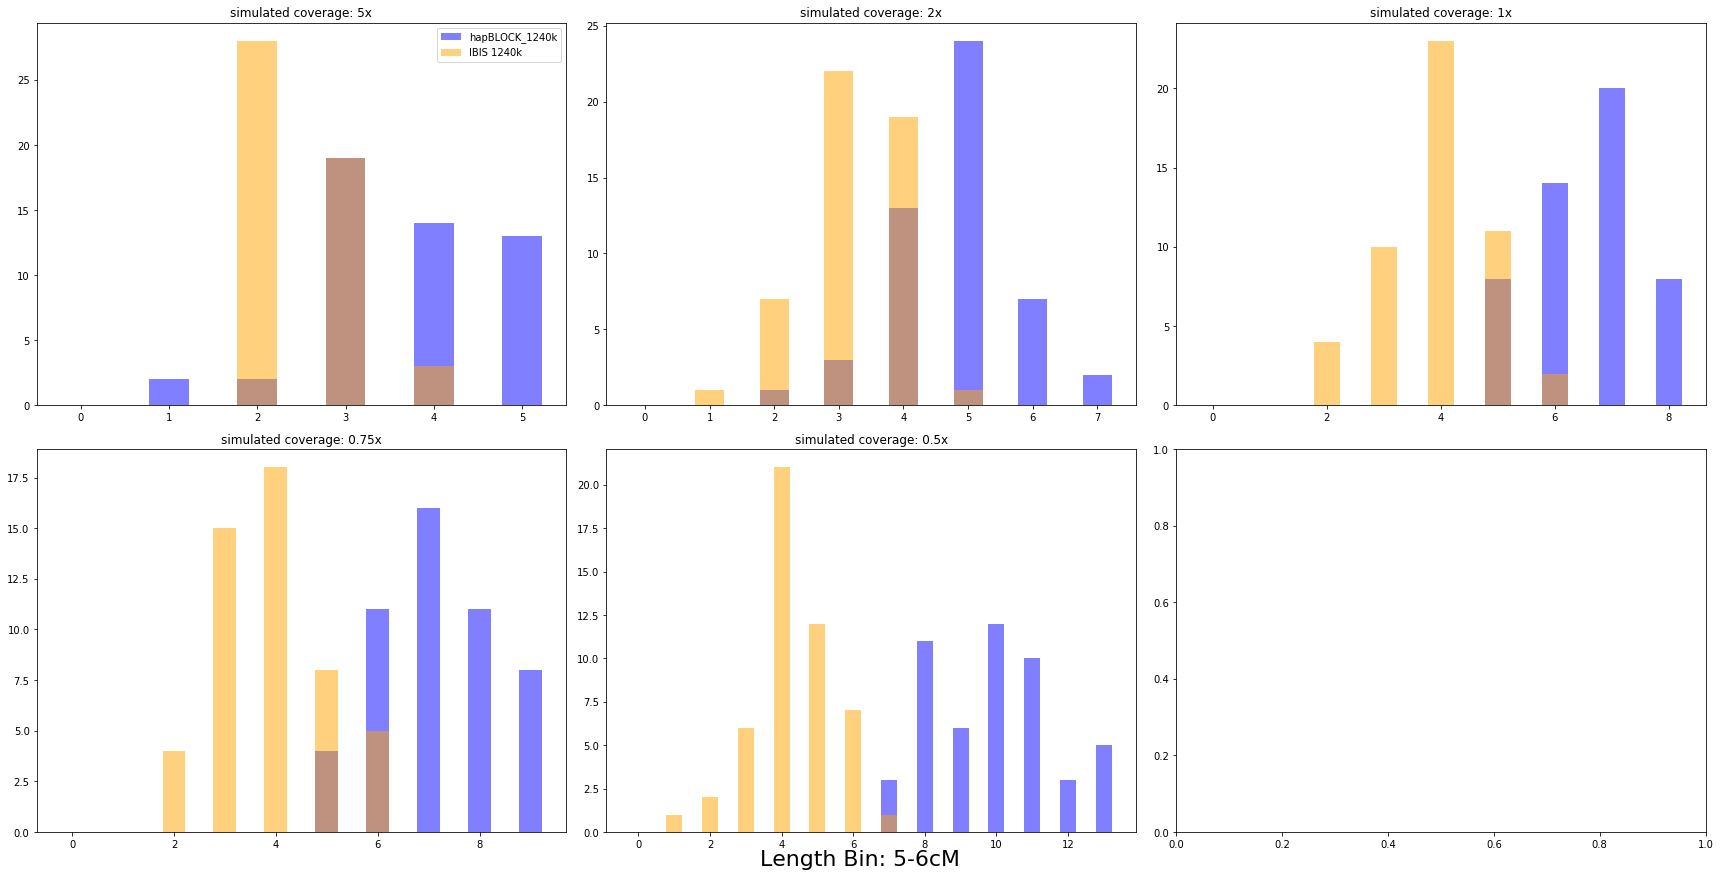

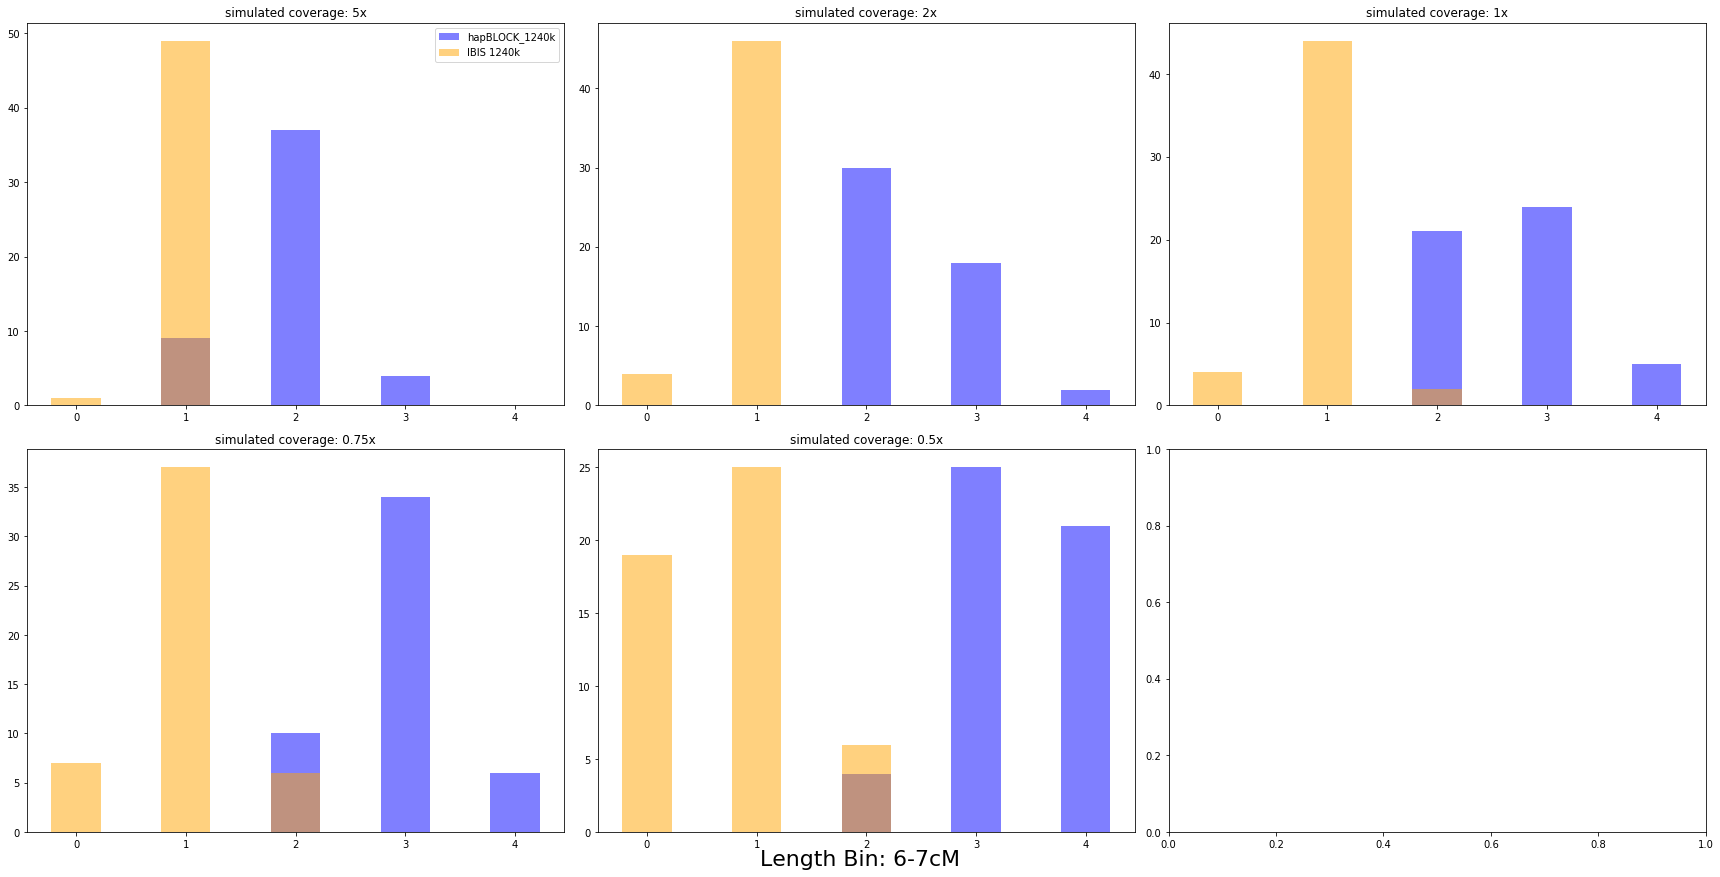

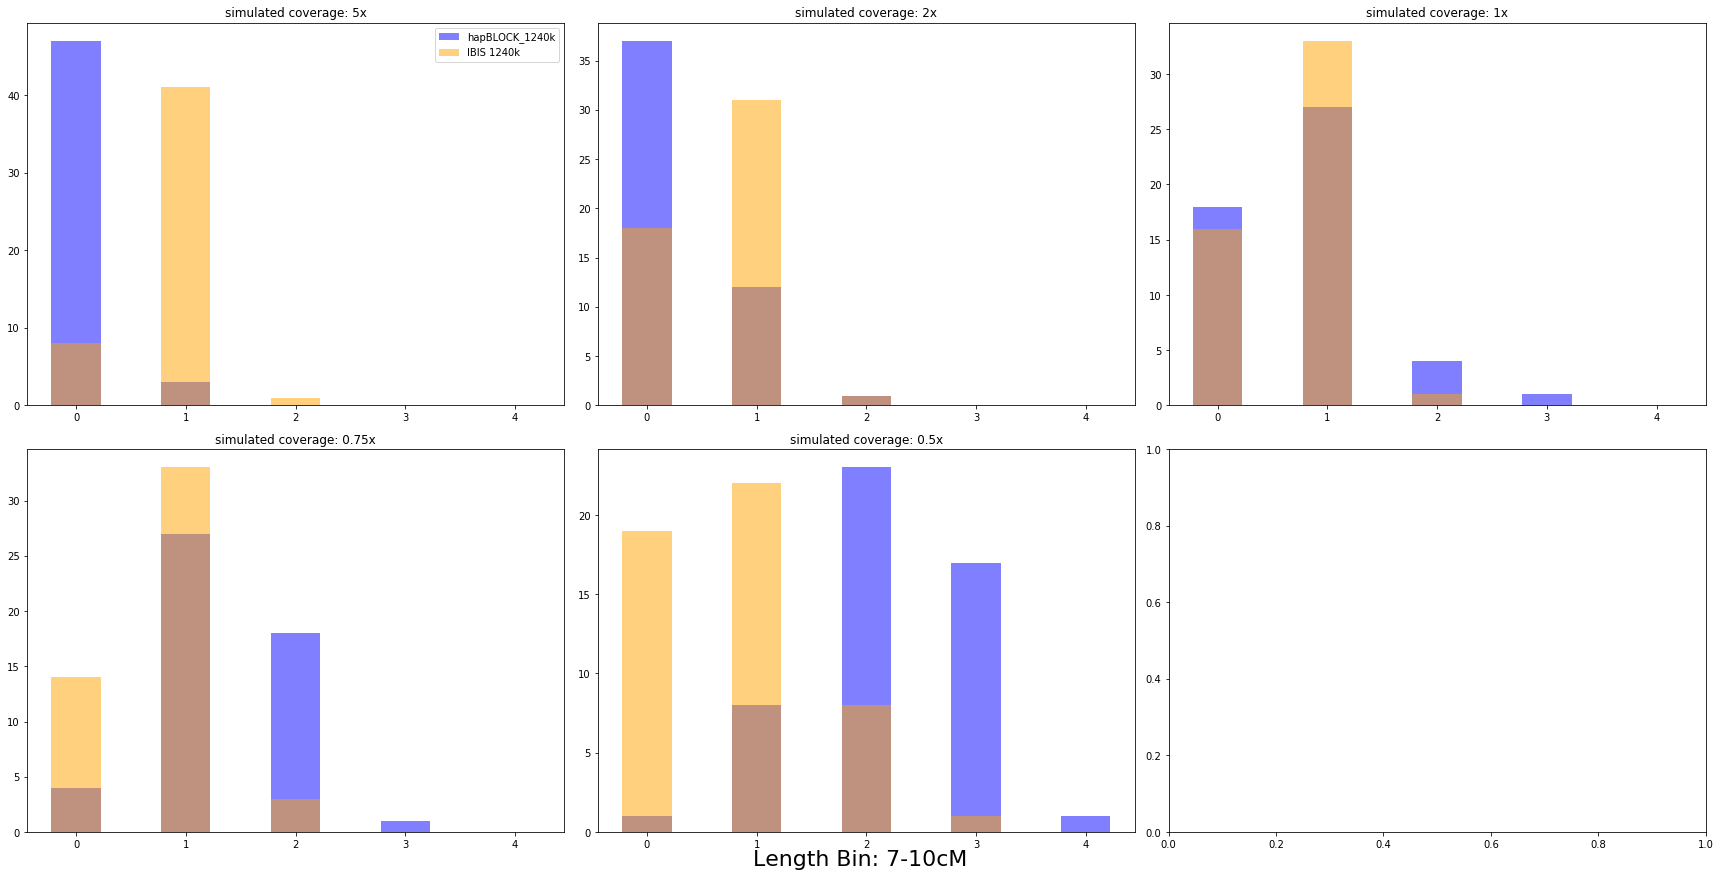

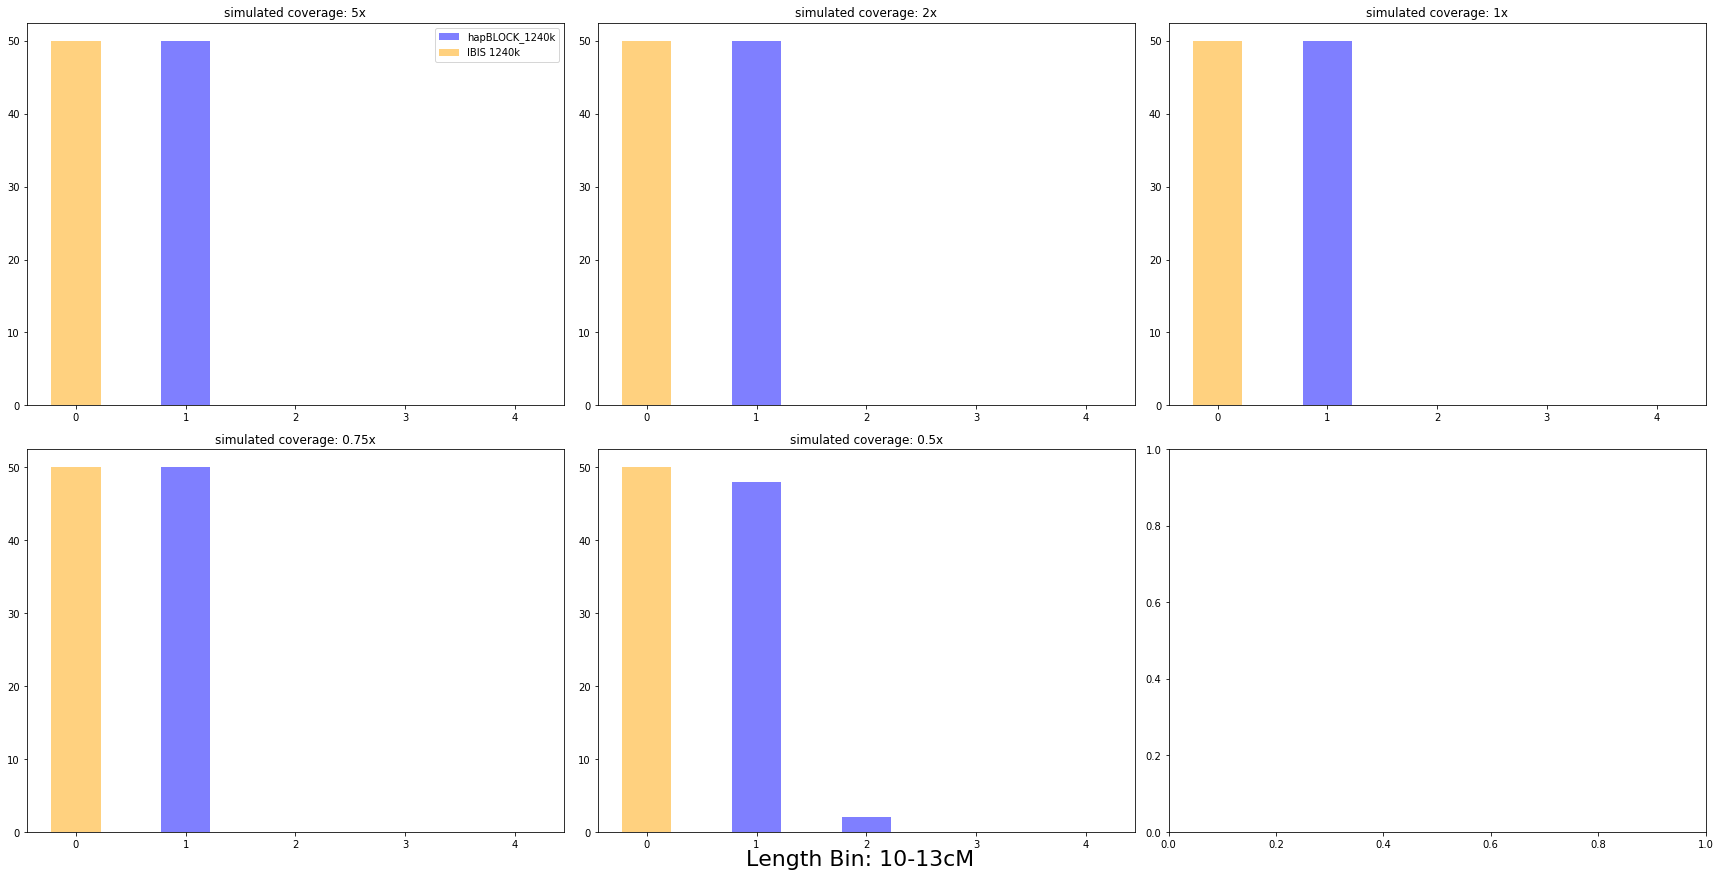

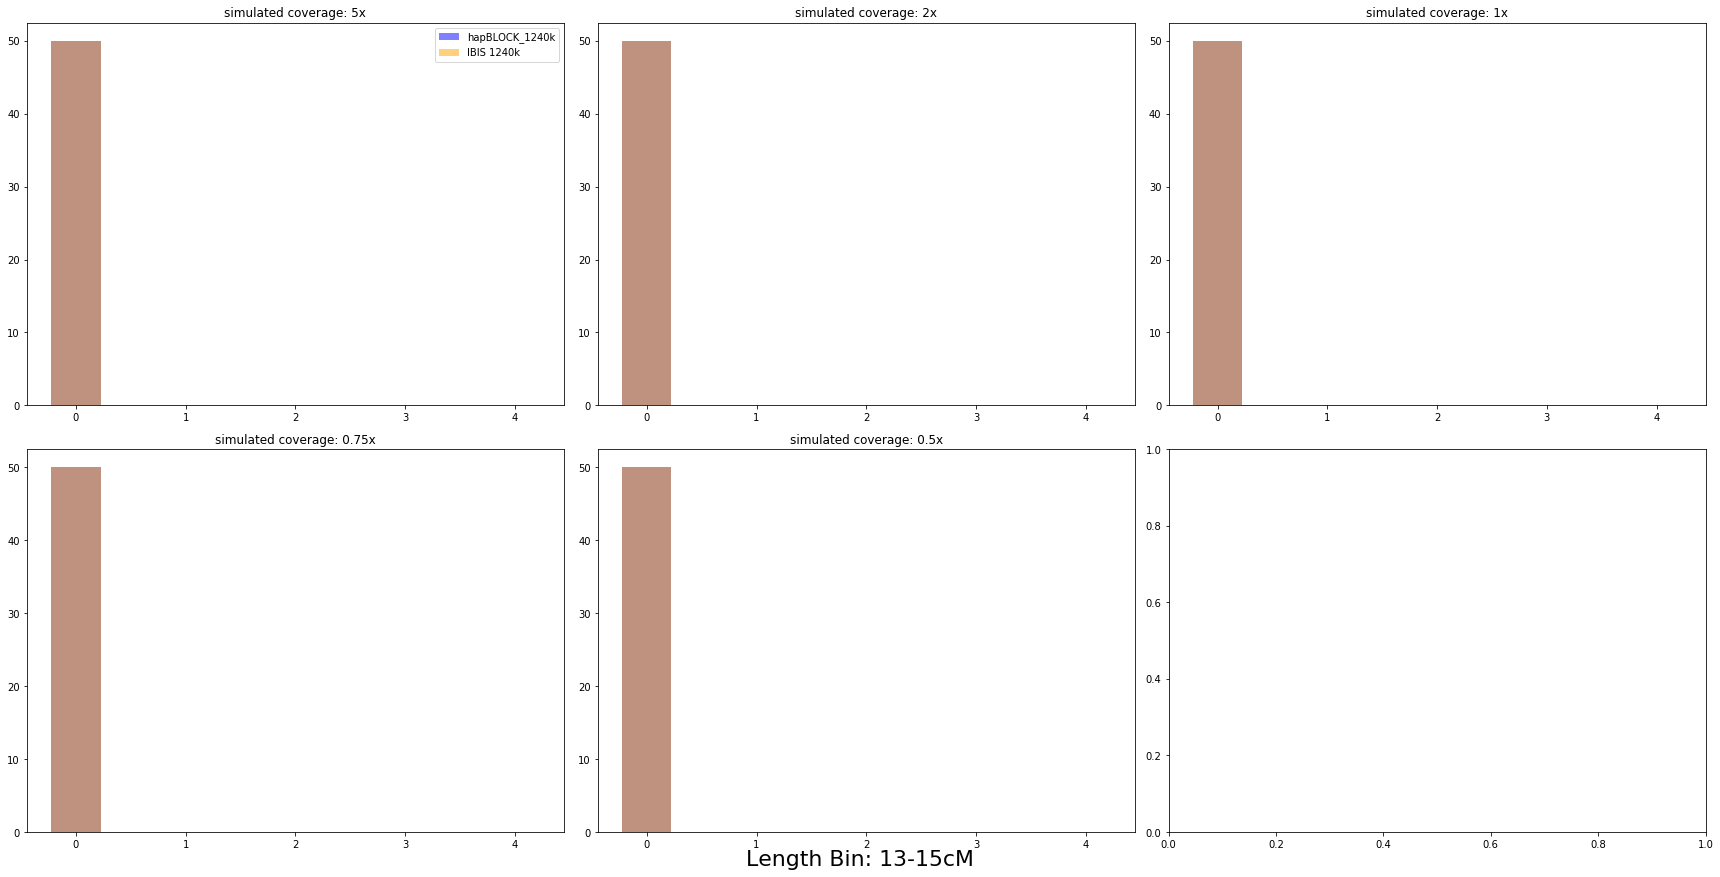

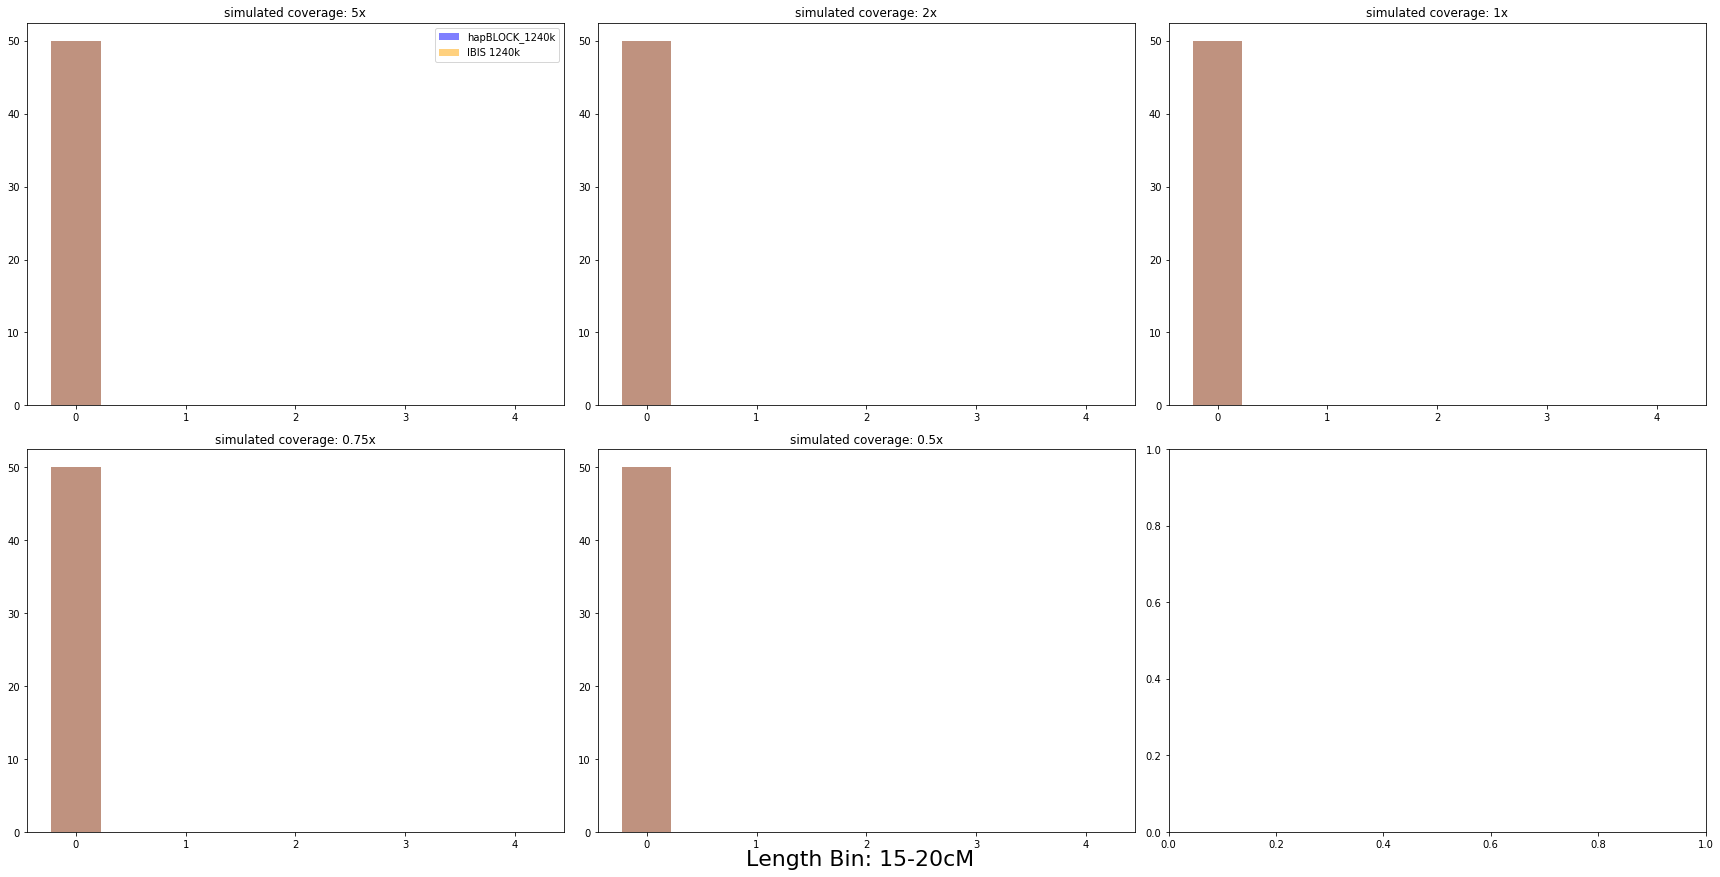

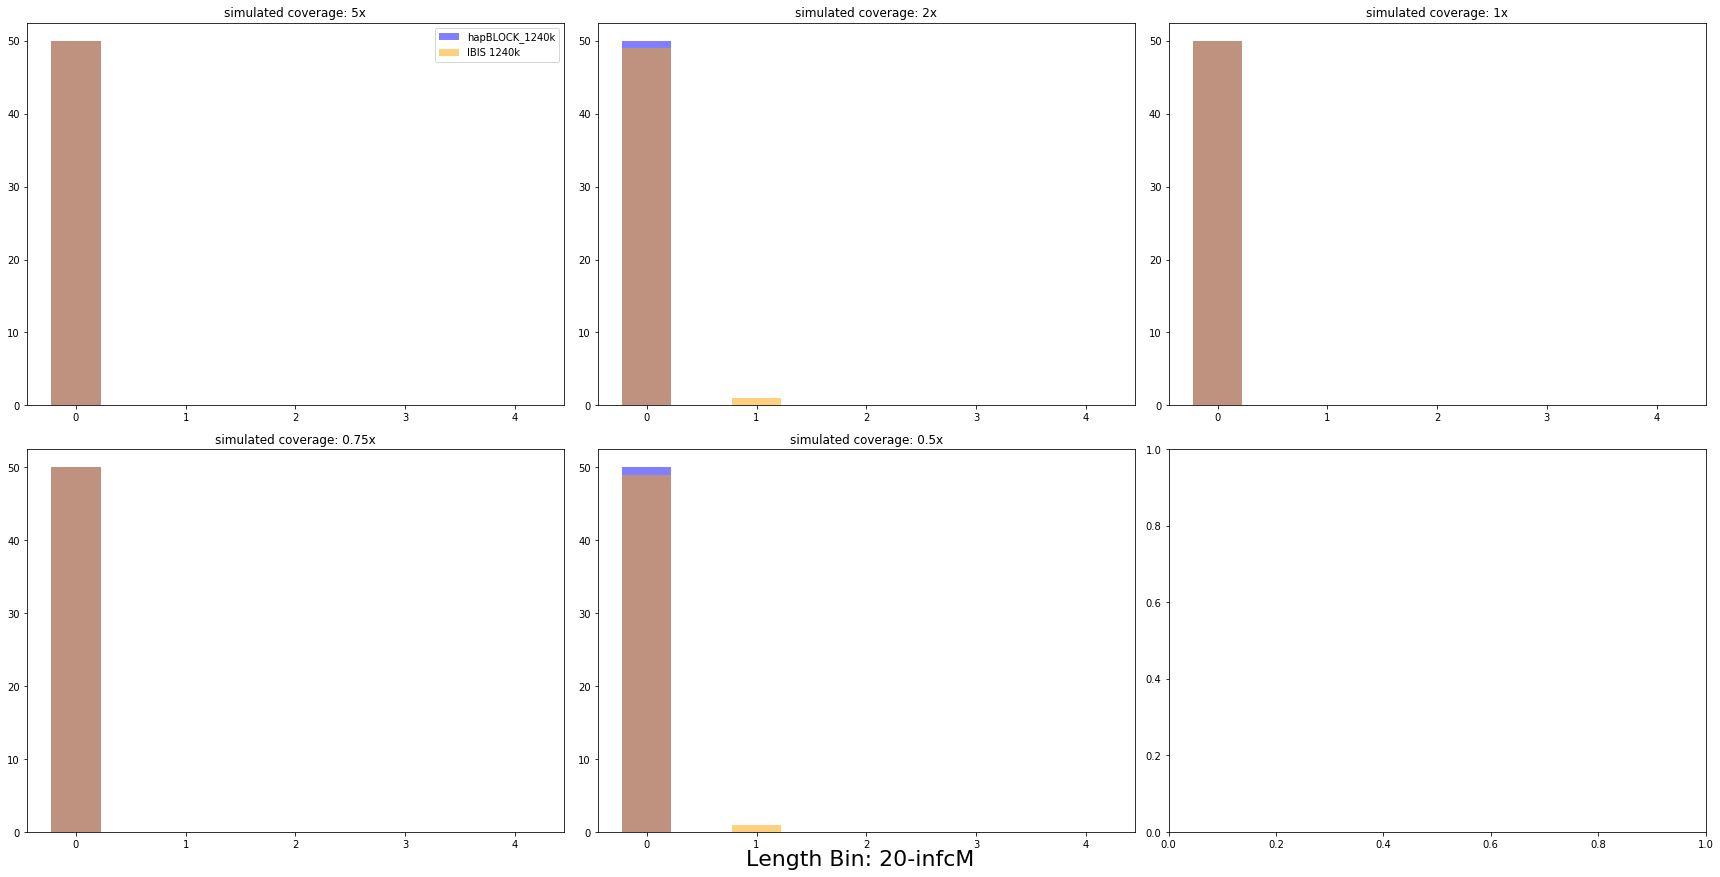

In [12]:
import matplotlib.pyplot as plt

bins = [(5,6),(6,7), (7,10), (10,13), (13,15), (15,20), (20, np.inf)]
covs = ['cov5', 'cov2', 'cov1', 'cov3over4', 'cov1over2']
cov2str = {'cov5':'5x', 'cov2':'2x', 'cov1':'1x', 'cov3over4':'0.75x', 'cov1over2':'0.5x'}

shift_x = 1e-3
shift_y = 1e-3


#masks = readMaskTrack('/mnt/archgen/users/yilei/tools/hapBLOCK/empirical/v51_6cM/mask.track')
masks = None

#path2GroundTruth = '/mnt/archgen/users/yilei/IBDsim/groundtruth_IBD_minDP20_wgs/merged.wgs.4cM_noFP_masked.seg'
path2GroundTruth = '/mnt/archgen/users/yilei/IBDsim/groundtruth_IBD_minDP20_wgs/merged.wgs.4cM_noFP.seg'

for i, bin in enumerate(bins):
    print(f'doing bin: {bin}')
    fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(24, 12), tight_layout=True)
    for index, cov in enumerate(covs):

        i, j = index//3, index%3
        fps1 = calc_FP_all(f'./callIBD/{cov}', bin[0], bin[1], path2GroundTruth, masks=masks, mode='hapBLOCK', threshold=0.5)
        fps2 = calc_FP_all(f'./callIBD/{cov}', bin[0], bin[1], path2GroundTruth, masks=masks, mode='IBIS_1240k', threshold=0.5)

        xmax = max(np.max(fps1), np.max(fps2))
        if xmax <= 5:
            xmax = 5
        axs[i,j].hist(fps1, label='hapBLOCK_1240k', color='blue', alpha=0.5, bins=np.arange(0, 1+xmax), align='left', rwidth=0.45)
        axs[i,j].hist(fps2, label='IBIS 1240k', color='orange', alpha=0.5, bins=np.arange(0,1+xmax), align='left', rwidth=0.45)

        axs[i,j].set_title(f'simulated coverage: {cov2str[cov]}')
        if i == j == 0:
            axs[i,j].legend(loc='upper right', fontsize='medium')

    fig.text(0.5, 0.0, f'Length Bin: {bin[0]}-{bin[1]}cM', ha='center', va='center', fontsize=22)
    plt.savefig(f'./FP/FP_{bin[0]}-{bin[1]}cM.png', dpi=300, bbox_inches = "tight")